In [262]:
import json

from tqdm.notebook import tqdm

import itertools
import os
import random
import pandas as pd

# web3
from solc import compile_standard
from eth_tester import PyEVMBackend, EthereumTester
import web3
web3.eth.handleRevert = True

# data & plotting
from matplotlib import pyplot as plt
import seaborn as sns

#from solc import install_solc
#install_solc('v0.4.25')

In [292]:
def get_contract(filename, contract_name):

    with open(filename) as f:
        compiled_sol = compile_standard({
            "language": "Solidity",
            "sources": {
                filename: {
                    "content": f.read()
                }
            },
            "settings": {
                "outputSelection": {
                    "*": {
                        "*": [
                            "metadata", "evm.bytecode",
                            "evm.bytecode.sourceMap"
                        ]
                    }
                }
            }
        })
    
    # get bytecode
    bytecode = compiled_sol['contracts'][filename][contract_name]['evm']['bytecode']['object']
    # get abi
    abi = json.loads(compiled_sol['contracts'][filename][contract_name]['metadata'])['output']['abi']

    contract = w3.eth.contract(abi=abi, bytecode=bytecode)

    # Submit the transaction that deploys the contract
    tx_hash = contract.constructor().transact()
    # Wait for the transaction to be mined, and get the transaction receipt
    tx_receipt = w3.eth.getTransactionReceipt(tx_hash)

    return w3.eth.contract(
        address=tx_receipt.contractAddress,
        abi=abi
    )

In [293]:
w3 = web3.Web3(web3.Web3.EthereumTesterProvider(EthereumTester(PyEVMBackend())))
w3.eth.default_account = w3.eth.accounts[0]

In [302]:
insertsort = get_contract('contracts/InsertionSort.sol', 'Median')
mergesort = get_contract('contracts/MergeSort.sol', 'Median')
quickselect = get_contract('contracts/QuickSort.sol', 'SelectK')
chainlink = get_contract('contracts/Chainlink.sol', 'Median2')
band = get_contract('contracts/Band.sol', 'MedianAggregator')

## Run tests

In [310]:
FILENAME = 'results.csv'

if os.path.exists(FILENAME):
    df = pd.read_csv(FILENAME, index_col=0)
else:
    df = pd.DataFrame({
        'length': pd.Series([], dtype='int'), 
        'gas_cost': pd.Series([], dtype='int'), 
        'type': pd.Series([], dtype='str'), 
        'arr': pd.Series([], dtype='int'), 
    })

In [316]:
def _median(arr):
    arr_copy = arr[:]
    arr_copy.sort()
    n = len(arr)
    if n % 2 == 1:
        return arr_copy[n // 2]
    else:
        return (arr_copy[n // 2 - 1] + arr_copy[n // 2]) / 2

def _arr_to_str(arr):
    return '-'.join([str(x) for x in arr])

def _insert(df, row):
    insert_loc = df.index.max()

    if pd.isna(insert_loc):
        df.loc[0] = row
    else:
        df.loc[insert_loc + 1] = row

NPERMS = 50

for n in tqdm(range(1, 30, 2)):
    
    arr = list(range(10, 10 * n + 1, 10))
    for r in range(NPERMS):
        
        assert len(arr) == n
        random.shuffle(arr)
        
        arr_str = _arr_to_str(arr)
        
        for (typ, fn) in [
            #('insertion-sort', insertsort.functions.compute),
            #('merge-sort', mergesort.functions.compute),
            #('quick-sort', quickselect.functions.computeAndSort),
            ('quick-select', quickselect.functions.median),
            #('quick-select-pivot', quickselect.functions.medianWithPivot),
            ('chainlink-inplace', chainlink.functions.calculateInplace),
            ('chainlink', chainlink.functions.calculate),
            ('band', band.functions.aggregate),
        ]:
            if ((df.type == typ) & (df.arr == arr_str)).any():
                # already computed
                # TODO: consider `df.set_index(['year', 'month'])`
                continue
                
            if typ == 'band':
                fn_ = fn(arr[:], len(arr))
            else:
                fn_ = fn(arr[:])
                
            #print(typ, fn)
            #print(arr)
            
            gas_cost = fn_.estimateGas()
            res = fn_.call()
            
            #print(res, _median(arr))
            
            assert res == _median(arr) # extra check, just in case
            row = [n, gas_cost, typ, arr_str]
            _insert(df, row)

    # save periodically
    df.to_csv(FILENAME)

In [ ]:
# color palettes
coolors = ["ff595e","ffca3a","8ac926","1982c4","6a4c93"]
colors = ['#' + c for c in coolors]
palette5 = sns.color_palette(colors)

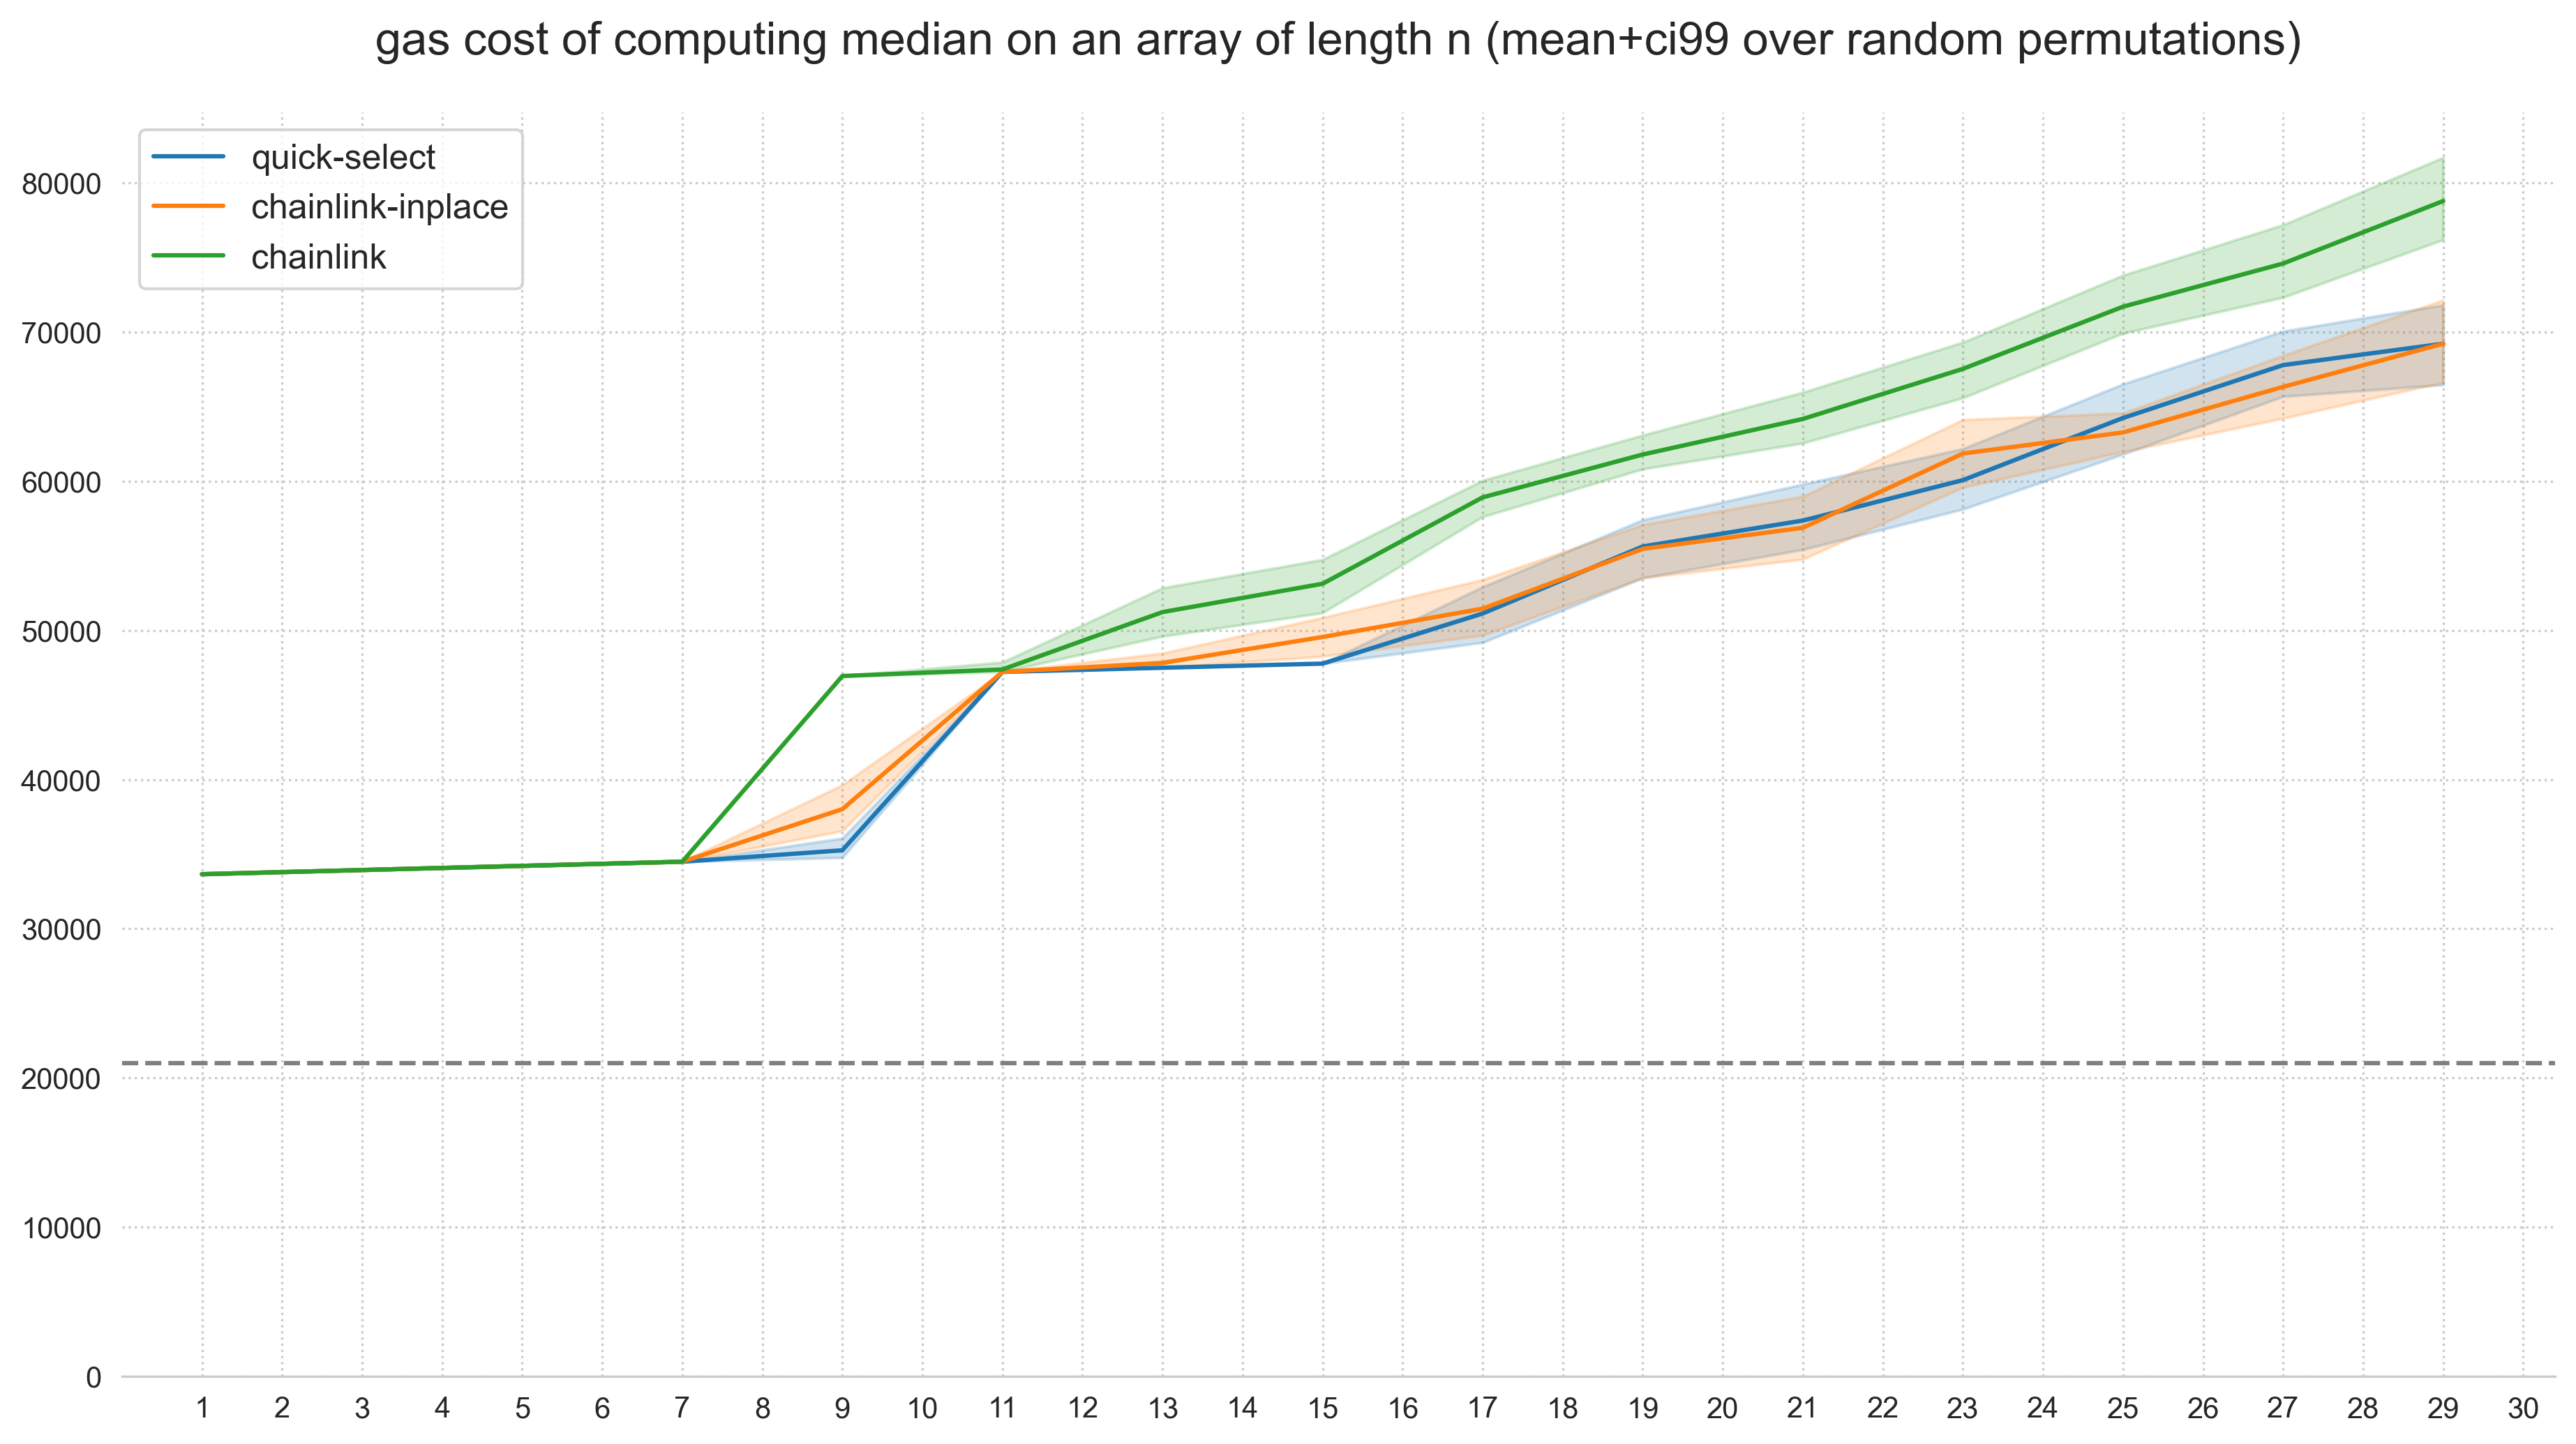

In [317]:
# first, make sure testing on same arrays
#'''
test_arrs = set()
for typ in df.type.unique():
    if not test_arrs:
        test_arrs = set(df[df.type == typ].arr.tolist())
    else:
        test_arrs &= set(df[df.type == typ].arr.tolist())
#'''

plt.figure(figsize=(15,8), dpi=300)

#g = sns.lineplot(data=df[df.arr.isin(test_arrs)], x="length", y="gas_cost", hue="type", ci=99)#, palette=palette5);
g = sns.lineplot(data=df[df.type != 'band'], x="length", y="gas_cost", hue="type", ci=99)#, palette=palette5);

# mark minimum gas for any txn
plt.axhline(21_000, ls='--', color='grey');


### aesthetics ###

sns.set_style(
    "whitegrid", {
        'grid.linestyle': ':'
})

plt.xlim(0,);
plt.ylim(0,);

g.set_title(
    'gas cost of computing median on an array of length n (mean+ci99 over random permutations)',
    size=16, pad=20
)
g.set_xlabel('', size=12)
g.set_xticks(list(range(1, 31)))
g.set_ylabel('')
plt.legend(fontsize=12)
g.tick_params(labelsize=10)

sns.despine(left=True);

In [281]:
df

,length,gas_cost,type,arr
0,1,33660,quick-select,10
1,1,33660,chainlink-inplace,10
2,1,33660,chainlink,10
3,1,33799,band,10
4,2,33799,quick-select,10-20
...,...,...,...,...
1919,27,134741,band,50-10-160-100-60-20-30-250-110-260-220-70-140-...
1920,27,73796,quick-select,210-170-20-140-260-270-250-180-50-30-230-100-1...
1921,27,73796,chainlink-inplace,210-170-20-140-260-270-250-180-50-30-230-100-1...
1922,27,85958,chainlink,210-170-20-140-260-270-250-180-50-30-230-100-1...


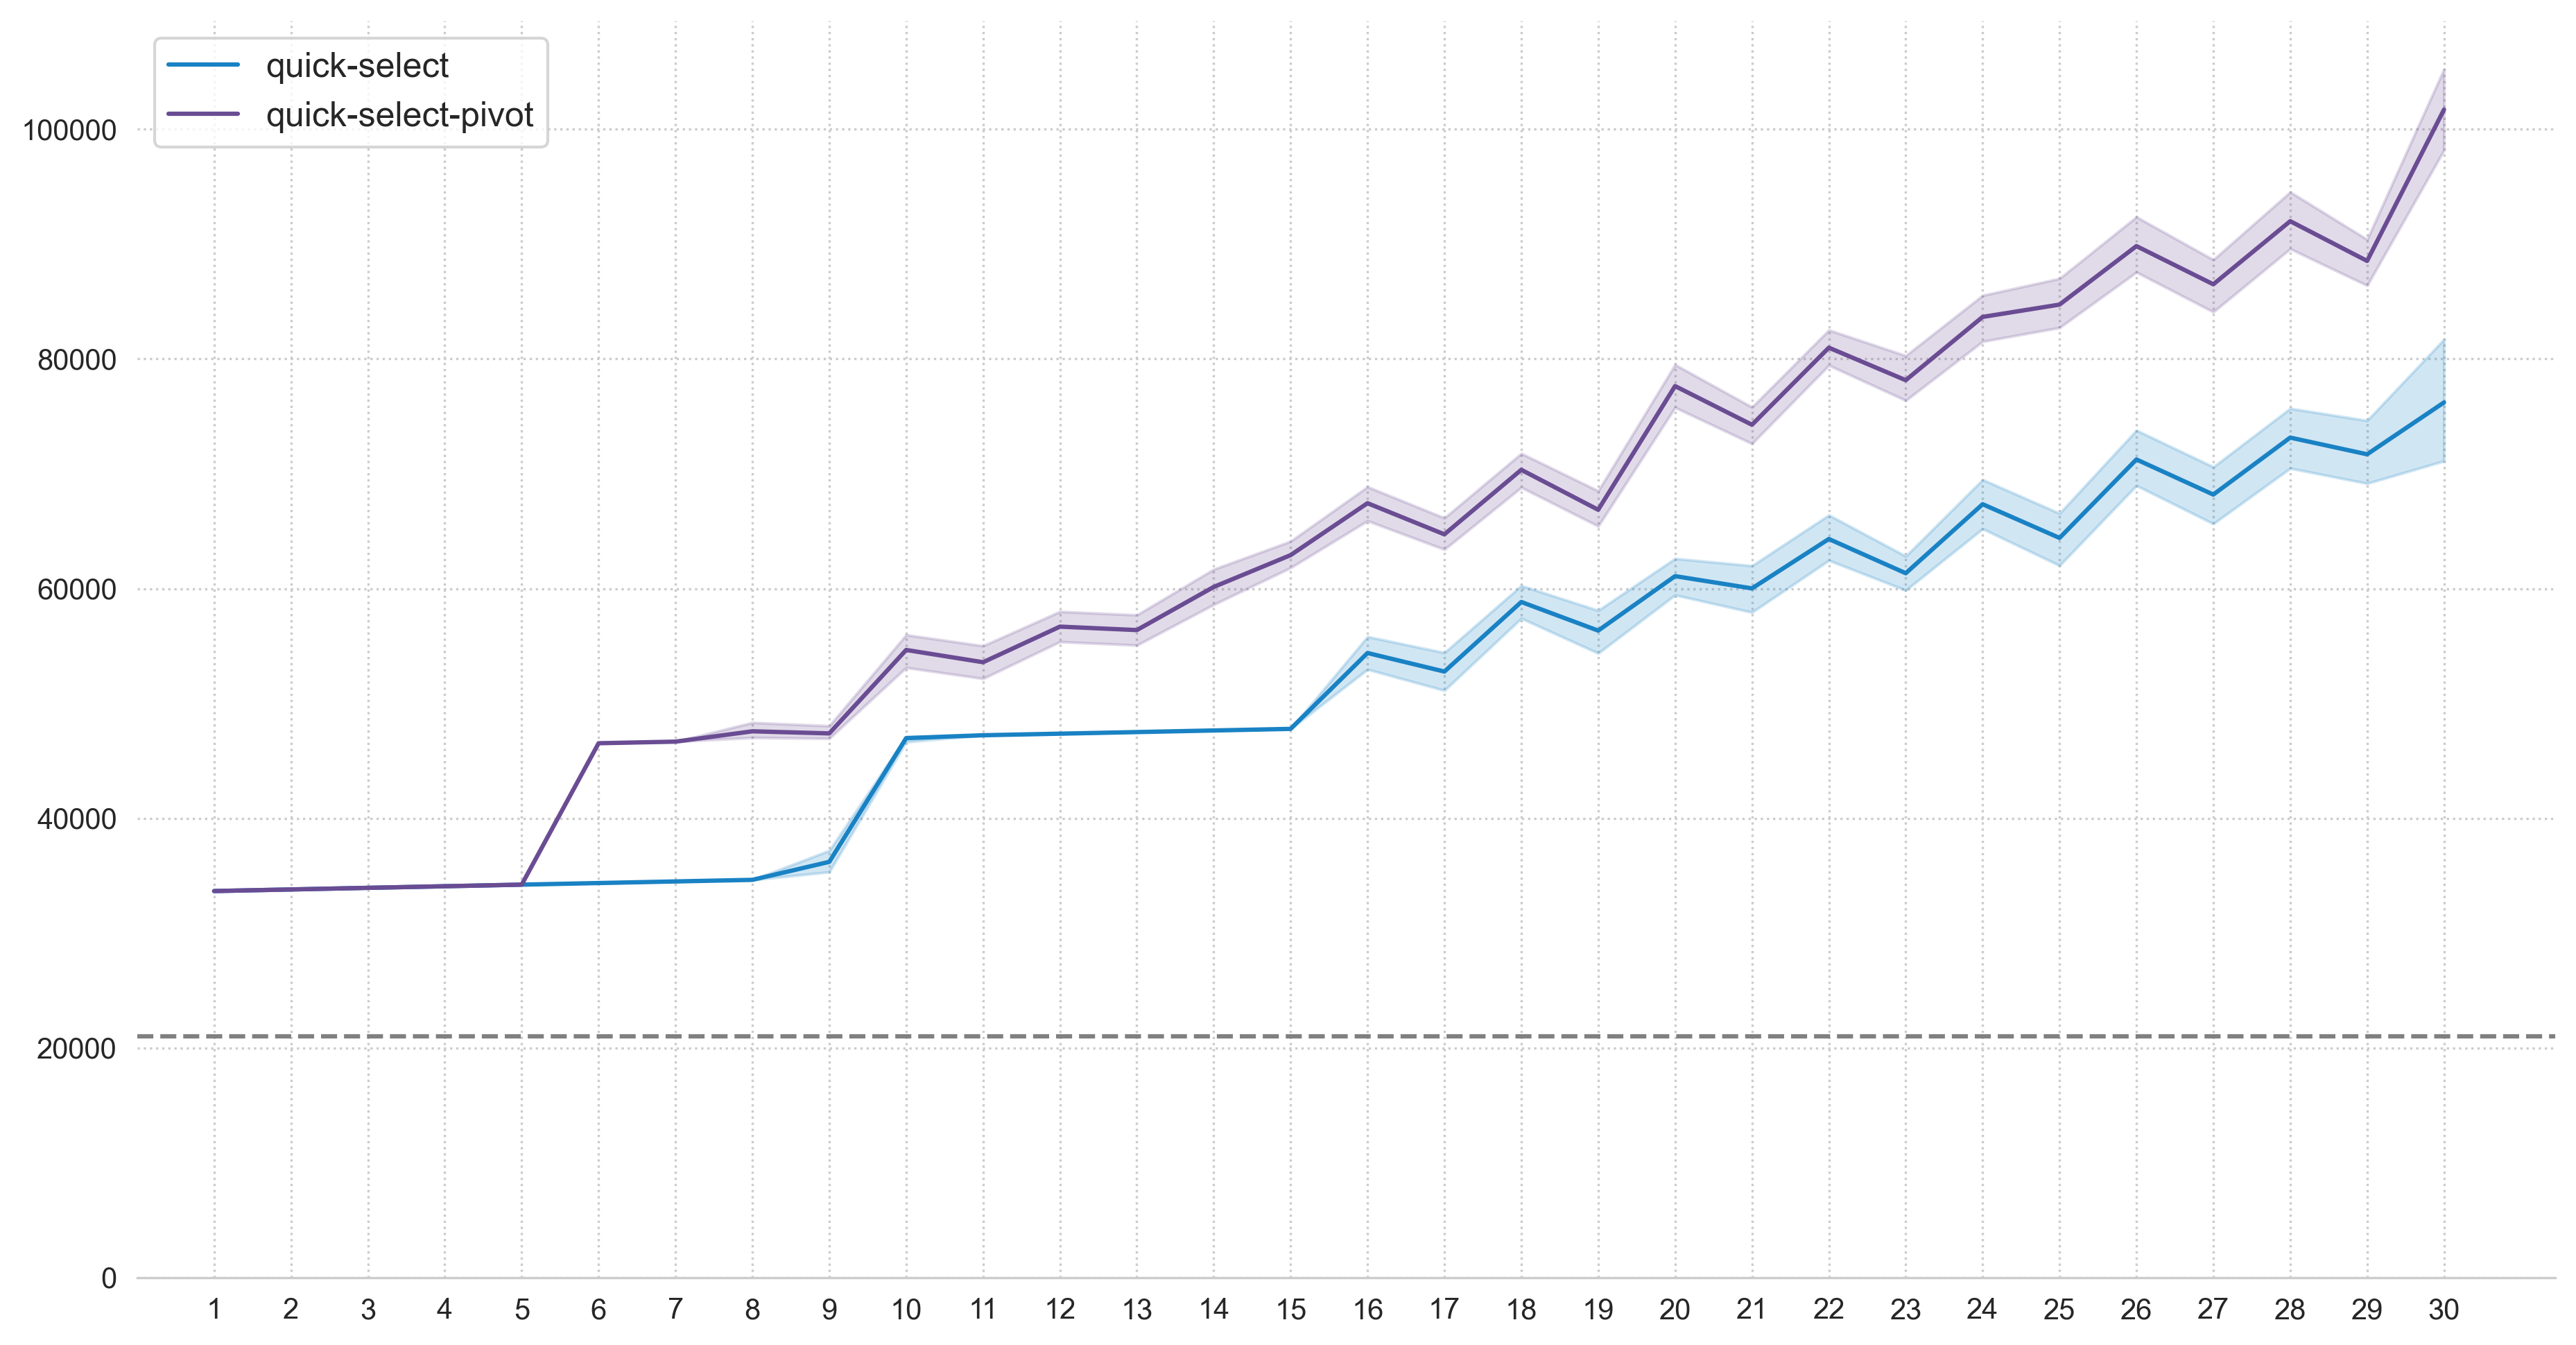

In [51]:
plt.figure(figsize=(15,8), dpi=300)

g = sns.lineplot(
    data=df[df.type.isin(['quick-select-pivot', 'quick-select'])],
    x="length", y="gas_cost", hue="type",
    ci=99, palette=palette5[-2:]
);

# mark minimum gas for any txn
plt.axhline(21_000, ls='--', color='grey');

### aesthetics ###

sns.set_style(
    "whitegrid", {
        'grid.linestyle': ':'
})

plt.xlim(0,);
plt.ylim(0,);

#g.set_title(
#    'gas cost of computing median on an array of length n (mean+ci99 over random permutations)',
#    size=16, pad=20
#)
g.set_xlabel('', size=12)
g.set_xticks(list(range(1, 31)))
g.set_ylabel('')
plt.legend(fontsize=12)
g.tick_params(labelsize=10)

sns.despine(left=True);

In [78]:
df

,length,gas_cost,type,arr
0,1,33661,insertion-sort,10
1,1,33661,merge-sort,10
2,1,33661,quick-sort,10
3,1,33661,quick-select,10
4,2,33800,insertion-sort,20-10
...,...,...,...,...
9491,28,98269,quick-select-pivot,270-70-80-130-60-100-120-180-280-20-240-190-23...
9492,28,61784,chainlink,270-70-80-130-60-100-120-180-280-20-240-190-23...
9493,29,74096,quick-select,50-130-210-220-150-110-230-180-20-290-120-250-...
9494,29,98418,quick-select-pivot,50-130-210-220-150-110-230-180-20-290-120-250-...


In [80]:
df

,length,gas_cost,type,arr
0,1,33661,insertion-sort,10
1,1,33661,merge-sort,10
2,1,33661,quick-sort,10
3,1,33661,quick-select,10
4,2,33800,insertion-sort,20-10
...,...,...,...,...
9491,28,98269,quick-select-pivot,270-70-80-130-60-100-120-180-280-20-240-190-23...
9492,28,61784,chainlink,270-70-80-130-60-100-120-180-280-20-240-190-23...
9493,29,74096,quick-select,50-130-210-220-150-110-230-180-20-290-120-250-...
9494,29,98418,quick-select-pivot,50-130-210-220-150-110-230-180-20-290-120-250-...


In [95]:
fn(arr[:])

ValidationError: 
Could not identify the intended function with name `aggregate`, positional argument(s) of type `(<class 'list'>,)` and keyword argument(s) of type `{}`.
Found 1 function(s) with the name `aggregate`: ['aggregate(uint256[],uint256)']
Function invocation failed due to improper number of arguments.

In [290]:
def quickSelect(arr, lo, hi, k):

    if lo == hi:
        return arr[k]


    while lo < hi:
        
        print(lo, hi)

        pivot = arr[lo];
        
        i = lo + 1
        j = hi

        while True:
            
            while i < len(arr) and arr[i] < pivot:
                i += 1
                
            while j > 0 and arr[j] > pivot:
                j -= 1
                
            if i >= j:
                arr[lo], arr[j] = arr[j], arr[lo]
                idx = j
                break
                
            arr[i], arr[j] = arr[j], arr[i]
            i += 1
            j -= 1

        if k == idx:
            return arr[k]

        if k < idx:
            hi = idx - 1
        else:
            lo = idx + 1

    return arr[k];

In [291]:
arr = [130,160,140,150,170,50,100,100,70,60,120,90,10,160,140,110,30]
n = len(arr)

quickSelect(arr, 0, n - 1, n // 2)

0 16
0 9
0 8
4 8
6 8


110